In [7]:
import jax
import jaxlib
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax.scipy import stats
from dataclasses import dataclass

In [8]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [9]:
# m1 chip compatible
print(f"jax: {jax.__version__}")
print(f"jaxlib: {jaxlib.__version__}")

jax: 0.2.10
jaxlib: 0.1.60


In [276]:
@dataclass
class GaussGamma:
    mu: float
    beta: float
    a: float
    b: float
    

def gaussian_gamma_pdf(mu, lmbda, params):
    """
    mu0 = c / beta
    a = 1 + beta / 2
    b = d - c ** 2/ (2 * beta)
    """
    N_part = stats.norm.pdf(mu, loc=params.mu, scale=1 / (params.beta * lmbda))
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part


def vb_est_pdf(mu, lmbda, params):
    N_part = stats.norm.pdf(mu, params.mu, 1 / params.beta)
    G_part = stats.gamma.pdf(lmbda, params.a, scale=1 / params.b)
    return N_part * G_part

In [277]:
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf, in_axes=(0, None, None))
gaussian_gamma_pdf_vmap = jax.vmap(gaussian_gamma_pdf_vmap, in_axes=(None, 0, None))

In [278]:
vb_est_pdf_vmap = jax.vmap(vb_est_pdf, in_axes=(0, None, None))
vb_est_pdf_vmap = jax.vmap(vb_est_pdf_vmap, in_axes=(None, 0, None))

In [279]:
mu0, beta, a, b = 0, 2, 5, 6
params = GaussGamma(mu0, beta, a, b)

In [280]:
npoints = 500
mu_range = jnp.linspace(-2, 2, npoints)
lambda_range = jnp.linspace(0, 2, npoints)

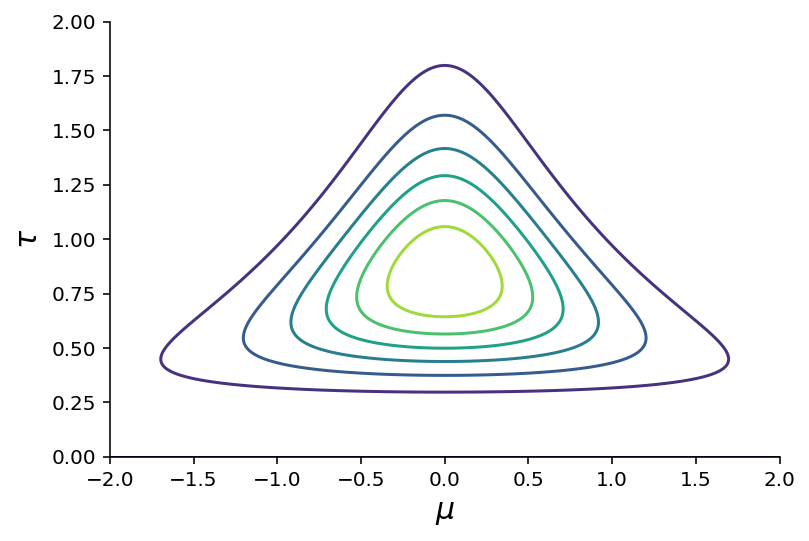

In [281]:
proba_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, params)
plt.contour(mu_range, lambda_range, proba_space)
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

## Univariate gaussian

$$
    q_\mu(\mu) = \mathcal{N}(\mu \vert \bar x, N \mathbb{E}_\tau[\tau])
$$

$$
    q_\tau(\tau) = \text{Gam}\left(\tau \Big\vert \frac{N}{2}, \frac{1}{2}\mathbb{E}_\mu\left[\sum_{n=1}^N(x_n - \mu)^2\right]\right),
$$

where
* $\mathbb{E}_\tau[\tau]^{-1} = \frac{1}{N-1}\sum_{n=1}^N (x_n - \bar x)^2$
* $\mathbb{E}_\mu[\mu] = N \bar{x^2} - N{\bar x}^2 + \frac{N}{\mathbb{E}_\tau[\tau]}$

In [354]:
key = random.PRNGKey(314)
N = 10

data = random.normal(key, (N, ))
data = (data - data.mean()) / data.std()

In [355]:
x_bar = jnp.mean(data)
mu_post = jnp.mean(data)
beta_post = N
a_post = N / 2
b_post = jnp.sum((data - mu_post) ** 2) / 2

posterior_params = GaussGamma(mu_post, beta_post, a_post, b_post)

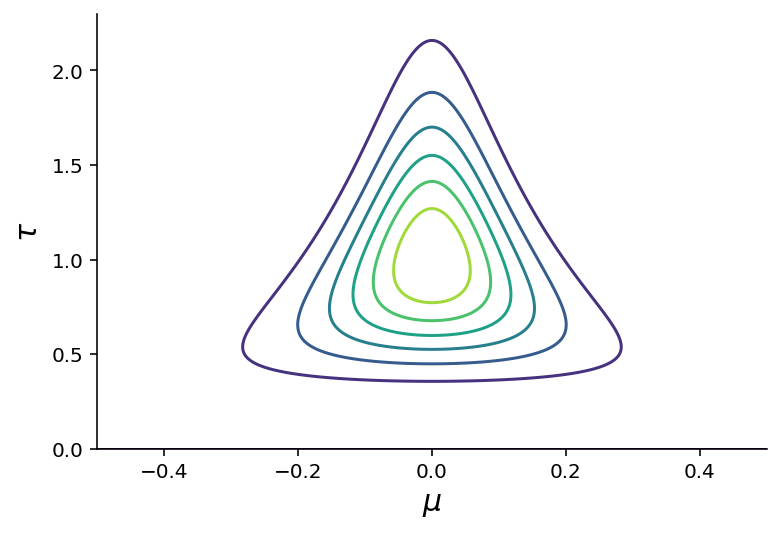

In [356]:
npoints = 500
mu_range = jnp.linspace(-1/2, 1/2, npoints)
lambda_range = jnp.linspace(0, 2.3, npoints)

proba_post_space = gaussian_gamma_pdf_vmap(mu_range, lambda_range, posterior_params)
plt.contour(mu_range, lambda_range, proba_post_space)
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

## All together

In [451]:
npoints = 500
mu_range = jnp.linspace(-1/2, 1/2, npoints)
lambda_range = jnp.linspace(0, 2, npoints)

In [452]:
a0, b0, mu0, beta0 = 0, 0, 0, 0
# Initial estimates
aN, bN = 2.5, 1
muN, betaN = 0.5, 5

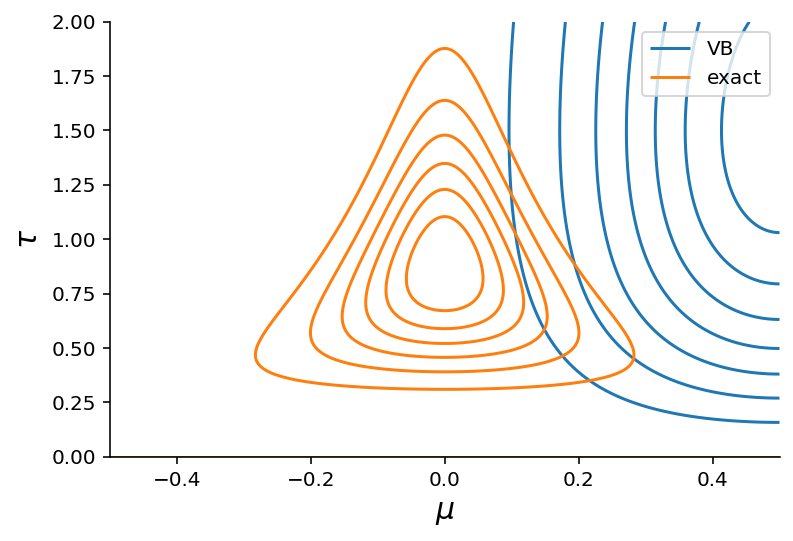

In [453]:
est_params = GaussGamma(muN, betaN, aN, bN)

proba_est_space = vb_est_pdf_vmap(mu_range, lambda_range, est_params)
contour_vb = plt.contour(mu_range, lambda_range, proba_est_space, colors="tab:blue")
contour_exact = plt.contour(mu_range, lambda_range, proba_post_space, colors="tab:orange")
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

contour_exact.collections[0].set_label("exact")
contour_vb.collections[0].set_label("VB")

plt.legend()

In [458]:
xbar = data.mean()

# update q_mu
e_tau = aN / bN
muN = (beta0 * mu0 + N * xbar) / (beta0 + N)
betaN = (beta0 + N) * e_tau

# update q_tau
e_mu = xbar
e_mu2 = 1 / betaN + muN ** 2
aN = a0 + (N + 1) / 2
bN = b0 + beta0 * (e_mu2 + mu0 ** 2 - 2 * mu0 * e_mu) / 2 + (data ** 2 + e_mu2 - 2 * e_mu * data).sum() / 2

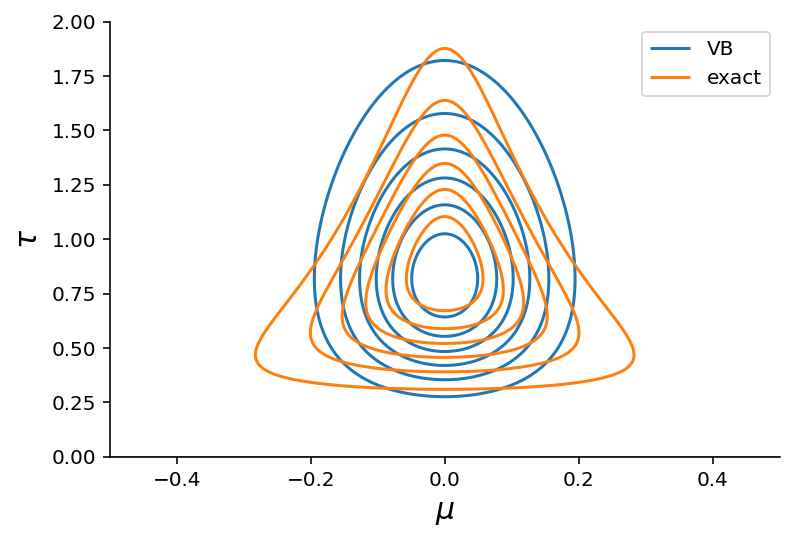

In [459]:
est_params = GaussGamma(muN, betaN, aN, bN)

proba_est_space = vb_est_pdf_vmap(mu_range, lambda_range, est_params)
contour_vb = plt.contour(mu_range, lambda_range, proba_est_space, colors="tab:blue")
contour_exact = plt.contour(mu_range, lambda_range, proba_post_space, colors="tab:orange")
plt.xlabel(r"$\mu$", fontsize=15)
plt.ylabel(r"$\tau$", fontsize=15);

contour_exact.collections[0].set_label("exact")
contour_vb.collections[0].set_label("VB")

plt.legend()

## References
* https://github.com/probml/pmtk3/blob/master/demos/unigaussVbDemo.m